In [1]:
import mhcflurry
import numpy
import seaborn
import logging
from matplotlib import pyplot

% matplotlib inline
logging.basicConfig(level="DEBUG")


Using Theano backend.
/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Making predictions
Note: if you haven't already, run `mhcflurry-downloads fetch` in a shell to download the trained models.

## Simplest way to run predictions: `mhcflurry.predict()`

In [2]:
help(mhcflurry.predict)

Help on function predict in module mhcflurry.predict:

predict(alleles, peptides, loaders=None)
    Make predictions across all combinations of the specified alleles and
    peptides.
    
    Parameters
    ----------
    alleles : list of str
        Names of alleles to make predictions for.
    
    peptides : list of str
        Peptide amino acid sequences.
    
    loaders : list of Class1AlleleSpecificPredictorLoader, optional
        Loaders to try. Will be tried in the order given.
    
    Returns DataFrame with columns "Allele", "Peptide", and "Prediction"



In [3]:
mhcflurry.predict(alleles=["HLA-A0201"], peptides=["SIINFEKL", "SIINFEQL"])

Allele   Peptide    Prediction
0  HLA-A0201  SIINFEKL  10672.347656
1  HLA-A0201  SIINFEQL   7828.974121

## Instantiating a model

In [4]:
model = mhcflurry.class1_allele_specific.load.from_allele_name("HLA-A0201")
model.predict(["SIINFEKL", "SIQNPEKP", "SYNFPEPI"])


array([ 10672.34765625,  30577.02539062,  10565.78222656], dtype=float32)

## Instantiating a model from a custom set of models on disk

In [5]:
models_dir = mhcflurry.downloads.get_path("models_class1_allele_specific_single")
models_dir

'/Users/tim/Library/Application Support/mhcflurry/4/0.0.8/models_class1_allele_specific_single/'

In [6]:
# Make a Loader first
loader = mhcflurry.class1_allele_specific.load.Class1AlleleSpecificPredictorLoader(models_dir)
model = loader.from_allele_name("HLA-A0201")
model.predict(["SIINFEKL", "SIQNPEKP", "SYNFPEPI"])

array([ 10672.34765625,  30577.02539062,  10565.78222656], dtype=float32)

# Loading a `Dataset`

In [7]:
full_training_data = mhcflurry.dataset.Dataset.from_csv(
    mhcflurry.downloads.get_path("data_combined_iedb_kim2014", "combined_human_class1_dataset.csv"))
full_training_data

Dataset(n=192550, alleles=['ELA-A1', 'Gogo-B0101', 'H-2-DB', 'H-2-DD', 'H-2-KB', 'H-2-KBM8', 'H-2-KD', 'H-2-KK', 'H-2-LD', 'H-2-LQ', 'HLA-A0101', 'HLA-A0201', 'HLA-A0202', 'HLA-A0203', 'HLA-A0204', 'HLA-A0205', 'HLA-A0206', 'HLA-A0207', 'HLA-A0210', 'HLA-A0211', 'HLA-A0212', 'HLA-A0216', 'HLA-A0217', 'HLA-A0219', 'HLA-A0250', 'HLA-A0301', 'HLA-A0302', 'HLA-A0319', 'HLA-A1', 'HLA-A11', 'HLA-A1101', 'HLA-A1102', 'HLA-A2', 'HLA-A2301', 'HLA-A24', 'HLA-A2402', 'HLA-A2403', 'HLA-A2501', 'HLA-A26', 'HLA-A2601', 'HLA-A2602', 'HLA-A2603', 'HLA-A2902', 'HLA-A3', 'HLA-A3/11', 'HLA-A3001', 'HLA-A3002', 'HLA-A3101', 'HLA-A3201', 'HLA-A3207', 'HLA-A3215', 'HLA-A3301', 'HLA-A6601', 'HLA-A6801', 'HLA-A6802', 'HLA-A6823', 'HLA-A6901', 'HLA-A7401', 'HLA-A8001', 'HLA-B0702', 'HLA-B0801', 'HLA-B0802', 'HLA-B0803', 'HLA-B1401', 'HLA-B1402', 'HLA-B1501', 'HLA-B1502', 'HLA-B1503', 'HLA-B1509', 'HLA-B1517', 'HLA-B1542', 'HLA-B1801', 'HLA-B27', 'HLA-B2701', 'HLA-B2702', 'HLA-B2703', 'HLA-B2704', 'HLA-B2705', 

In [8]:
kim2014_full = mhcflurry.dataset.Dataset.from_csv(
    mhcflurry.downloads.get_path("data_kim2014", "bdata.20130222.mhci.public.1.txt"))

kim2014_train = mhcflurry.dataset.Dataset.from_csv(
    mhcflurry.downloads.get_path("data_kim2014", "bdata.2009.mhci.public.1.txt"))
kim2014_test = mhcflurry.dataset.Dataset.from_csv(
    mhcflurry.downloads.get_path("data_kim2014", "bdata.2013.mhci.public.blind.1.txt"))

len(kim2014_full), len(kim2014_train), len(kim2014_test)

(179692, 137654, 27680)

# Predicting affinities from a `Dataset`


In [9]:
model = mhcflurry.class1_allele_specific.load.from_allele_name("HLA-A0201")
model.predict(kim2014_train.get_allele("HLA-A0201").peptides)


array([  3514.14550781,  12429.5390625 ,   4227.02197266, ...,
         5949.32763672,  17837.0859375 ,   6724.96728516], dtype=float32)

# Fit a model

In [10]:
help(mhcflurry.class1_allele_specific.Class1BindingPredictor)

Help on class Class1BindingPredictor in module mhcflurry.class1_allele_specific.class1_binding_predictor:

class Class1BindingPredictor(mhcflurry.class1_allele_specific.class1_allele_specific_kmer_ic50_predictor_base.Class1AlleleSpecificKmerIC50PredictorBase)
 |  Allele-specific Class I MHC binding predictor which uses
 |  fixed-length (k-mer) index encoding for inputs and outputs
 |  a value between 0 and 1 (where 1 is the strongest binder).
 |  
 |  Method resolution order:
 |      Class1BindingPredictor
 |      mhcflurry.class1_allele_specific.class1_allele_specific_kmer_ic50_predictor_base.Class1AlleleSpecificKmerIC50PredictorBase
 |      mhcflurry.ic50_predictor_base.IC50PredictorBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, model=None, name=None, max_ic50=50000.0, allow_unknown_amino_acids=True, kmer_size=9, n_amino_acids=20, verbose=False, **hyperparameters)
 |      Initialize self.  See help(type(self)) for accur

In [11]:
train_data = kim2014_train.get_allele("HLA-A3301")
train_data

Dataset(n=3040, alleles=['HLA-A3301'])

In [12]:
# We'll use the default hyper parameters here. Could also specify them as kwargs:
new_model = mhcflurry.class1_allele_specific.Class1BindingPredictor()
new_model.hyperparameters

{'activation': 'tanh',
 'batch_normalization': True,
 'batch_size': 128,
 'dropout_probability': 0.0,
 'embedding_output_dim': 32,
 'fraction_negative': 0.0,
 'init': 'glorot_uniform',
 'kmer_size': 9,
 'layer_sizes': [64],
 'loss': 'mse',
 'max_ic50': 50000.0,
 'n_training_epochs': 250,
 'optimizer': 'rmsprop',
 'output_activation': 'sigmoid',
 'pretrain_decay': 'numpy.exp(-epoch)'}

In [13]:
# This will run faster if you have a GPU.
%time new_model.fit_dataset(train_data)

CPU times: user 1min 22s, sys: 1.13 s, total: 1min 24s
Wall time: 45.8 s


## Evaluate the fit model on held-out test data

### Generate predictions

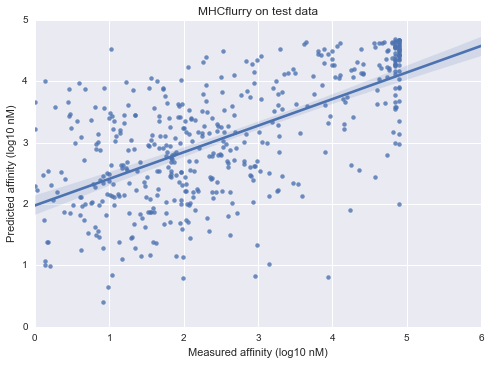

In [14]:
test_data = kim2014_test.get_allele("HLA-A3301")
predictions = new_model.predict(test_data.peptides)

seaborn.set_context('notebook')
seaborn.regplot(numpy.log10(test_data.affinities), numpy.log10(predictions))
pyplot.xlim(xmin=0)
pyplot.ylim(ymin=0)
pyplot.xlabel("Measured affinity (log10 nM)")
pyplot.ylabel("Predicted affinity (log10 nM)")
pyplot.title("MHCflurry on test data")

### Calculate AUC, F1, and Kendall's Tau scores

In [15]:
help(mhcflurry.class1_allele_specific.scoring.make_scores)

Help on function make_scores in module mhcflurry.class1_allele_specific.scoring:

make_scores(ic50_y, ic50_y_pred, sample_weight=None, threshold_nm=500, max_ic50=50000)
    Calculate AUC, F1, and Kendall Tau scores.
    
    Parameters
    -----------
    ic50_y : float list
        true IC50s (i.e. affinities)
    
    ic50_y_pred : float list
        predicted IC50s
    
    sample_weight : float list [optional]
    
    threshold_nm : float [optional]
    
    max_ic50 : float [optional]
    
    Returns
    -----------
    dict with entries "auc", "f1", "tau"



In [16]:
mhcflurry.class1_allele_specific.scoring.make_scores(test_data.affinities, predictions)

{'auc': 0.84099099099099106,
 'f1': 0.65531914893617027,
 'tau': 0.43387627983717181}

## Cross validation for hyperparameter selection

In [17]:
help(mhcflurry.class1_allele_specific.cross_validation.cross_validation_folds)

Help on function cross_validation_folds in module mhcflurry.class1_allele_specific.cross_validation:

cross_validation_folds(train_data, alleles=None, n_folds=3, drop_similar_peptides=False, imputer=None, impute_kwargs={'min_observations_per_allele': 2, 'min_observations_per_peptide': 2}, parallel_backend=None)
    Split a Dataset into n_folds cross validation folds for each allele,
    optionally performing imputation.
    
    Parameters
    -----------
    train_data : mhcflurry.Dataset
    
    alleles : string list, optional
        Alleles to run cross validation on. Default: all alleles in
        train_data.
    
    n_folds : int, optional
        Number of cross validation folds for each allele.
    
    drop_similar_peptides : boolean, optional
        For each fold, remove peptides from the test data that are similar
        to peptides in the train data. Similarity is defined as in the
        similar_peptides function.
    
    imputer : fancyimpute.Solver, optional
     

In [18]:
folds = mhcflurry.class1_allele_specific.cross_validation.cross_validation_folds(train_data)
folds

[AlleleSpecificTrainTestFold(allele='HLA-A3301', train=Dataset(n=2026, alleles=['HLA-A3301']), imputed_train=None, test=Dataset(n=1014, alleles=['HLA-A3301'])),
 AlleleSpecificTrainTestFold(allele='HLA-A3301', train=Dataset(n=2027, alleles=['HLA-A3301']), imputed_train=None, test=Dataset(n=1013, alleles=['HLA-A3301'])),
 AlleleSpecificTrainTestFold(allele='HLA-A3301', train=Dataset(n=2027, alleles=['HLA-A3301']), imputed_train=None, test=Dataset(n=1013, alleles=['HLA-A3301']))]

In [19]:
# Take a look at what hyperparameters are available for searching over.
mhcflurry.class1_allele_specific.train.HYPERPARAMETER_DEFAULTS.defaults

{'activation': 'tanh',
 'batch_normalization': True,
 'batch_size': 128,
 'dropout_probability': 0.0,
 'embedding_output_dim': 32,
 'fraction_negative': 0.0,
 'impute': False,
 'init': 'glorot_uniform',
 'kmer_size': 9,
 'layer_sizes': [64],
 'loss': 'mse',
 'max_ic50': 50000.0,
 'n_training_epochs': 250,
 'optimizer': 'rmsprop',
 'output_activation': 'sigmoid',
 'pretrain_decay': 'numpy.exp(-epoch)'}

In [20]:
models_to_search = mhcflurry.class1_allele_specific.train.HYPERPARAMETER_DEFAULTS.models_grid(
    fraction_negative=[.1],
    layer_sizes=[[8], [12]])
print("Searching over %d models." % len(models_to_search))
print("First model: \n%s" % models_to_search[0])

Searching over 2 models.
First model: 
{'output_activation': 'sigmoid', 'pretrain_decay': 'numpy.exp(-epoch)', 'n_training_epochs': 250, 'embedding_output_dim': 32, 'optimizer': 'rmsprop', 'loss': 'mse', 'fraction_negative': 0.1, 'batch_normalization': True, 'dropout_probability': 0.0, 'init': 'glorot_uniform', 'activation': 'tanh', 'batch_size': 128, 'impute': False, 'kmer_size': 9, 'max_ic50': 50000.0, 'layer_sizes': [8]}


In [21]:
help(mhcflurry.class1_allele_specific.train.train_across_models_and_folds)

Help on function train_across_models_and_folds in module mhcflurry.class1_allele_specific.train:

train_across_models_and_folds(folds, model_descriptions, cartesian_product_of_folds_and_models=True, return_predictors=False, folds_per_task=1, parallel_backend=None)
    Train and optionally test any number of models across any number of folds.
    
    Parameters
    -----------
    folds : list of AlleleSpecificTrainTestFold
    
    model_descriptions : list of dict
        Models to test
    
    cartesian_product_of_folds_and_models : boolean, optional
        If true, then a predictor is treained for each fold and model
        description.
        If false, then len(folds) must equal len(model_descriptions), and
        the i'th model is trained on the i'th fold.
    
    return_predictors : boolean, optional
        Include the trained predictors in the result.
    
    parallel_backend : mhcflurry.parallelism.ParallelBackend, optional
        Futures implementation to use for run

In [22]:
results_df = mhcflurry.class1_allele_specific.train.train_across_models_and_folds(
    folds,
    models_to_search,
    return_predictors=True)
results_df

allele  fold_num  model_num  train_size  test_size imputed_train_size  \
0  HLA-A3301         0          0        2026       1014               None   
1  HLA-A3301         0          1        2026       1014               None   
2  HLA-A3301         1          0        2027       1013               None   
3  HLA-A3301         1          1        2027       1013               None   
4  HLA-A3301         2          0        2027       1013               None   
5  HLA-A3301         2          1        2027       1013               None   

   train_tau  train_auc  train_f1  test_tau        ...         \
0   0.710233   0.989589  0.902256  0.429803        ...          
1   0.747597   0.993938  0.919708  0.425610        ...          
2   0.705507   0.990185  0.882466  0.430678        ...          
3   0.745532   0.993875  0.924812  0.395103        ...          
4   0.709275   0.992395  0.894531  0.441365        ...          
5   0.743498   0.994674  0.873518  0.439221        ...          

   model_fraction_negative  model_batch_normalization  \
0                      0.1                       True   
1                      0.1                       True   
2                      0.1                       True   
3                      0.1                       True   
4                      0.1                       True   
5                      0.1                       True   

  model_dropout_probability      model_init  model_activation  \
0                       0.0  glorot_uniform              tanh   
1                       0.0  glorot_uniform              tanh   
2                       0.0  glorot_uniform              tanh   
3                       0.0  glorot_uniform              tanh   
4                       0.0  glorot_uniform              tanh   
5                       0.0  glorot_uniform              tanh   

  model_batch_size model_impute  model_kmer_size  model_max_ic50  \
0              128        False                9         50000.0   
1              128        False                9         50000.0   
2              128        False                9         50000.0   
3              128        False                9         50000.0   
4              128        False                9         50000.0   
5              128        False                9         50000.0   

  model_layer_sizes  
0               [8]  
1              [12]  
2               [8]  
3              [12]  
4               [8]  
5              [12]  

[6 rows x 31 columns]

In [23]:
# The trained predictors are in the 'predictor' column
results_df.predictor

0    Class1BindingPredictor(name=None, max_ic50=500...
1    Class1BindingPredictor(name=None, max_ic50=500...
2    Class1BindingPredictor(name=None, max_ic50=500...
3    Class1BindingPredictor(name=None, max_ic50=500...
4    Class1BindingPredictor(name=None, max_ic50=500...
5    Class1BindingPredictor(name=None, max_ic50=500...
Name: predictor, dtype: object

In [24]:
# Which model had the best average AUC across folds?
results_df.groupby("model_num").test_auc.mean()

model_num
0    0.859859
1    0.847004
Name: test_auc, dtype: float64